In [ ]:
!pip install category_encoders

     |████████████████████████████████| 81kB 6.9MB/s 


In [ ]:
!pip install neptune-client

     |████████████████████████████████| 225kB 19.7MB/s 
     |████████████████████████████████| 829kB 36.5MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
     |████████████████████████████████| 163kB 47.1MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
     |████████████████████████████████| 133kB 47.8MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.9.7-py2.py3-none-any.whl size=389578 sha256=49d0a5143d07a2a3677e480bfab07d32f877b1d657f4ff9847e56548943650cc
  Stored in directory: /root/.cache/pip/wheels/bd/17/9e/9160edeebe214e70b7cbe39374f989e52290f635f2262785a6
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=ebdb3c7f4b9c580c288f2aa3ace6dba2dedd517296d8d589090b2eb5a9e954ee
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp37-none-an

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

import six
import sys
sys.modules['sklearn.externals.six'] = six

from imblearn.combine import SMOTETomek
from datetime import datetime
from sklearn.compose import ColumnTransformer

from sklearn.metrics import classification_report, make_scorer, f1_score, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold

from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform
import matplotlib.pyplot as plt

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import xgboost as xgb

from sklearn.model_selection import train_test_split

from sklearn.metrics import plot_confusion_matrix


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
import neptune

API_TOKEN='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiYmM4OTBkYTAtY2JlYi00MGM4LWIzZTUtYzg1MTJkMzJkYjk3In0=' #@param {type:"string"}

PROJEKT_NAME = 'DataWorkshop-Foundation/Predicting-cancellation-of-visit' 

neptune.init(
   api_token=API_TOKEN,
   project_qualified_name=PROJEKT_NAME
)

Project(DataWorkshop-Foundation/Predicting-cancellation-of-visit)

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cancellation/data/KaggleV2-May-2016.csv')
dataset

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,2.572134e+12,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No
110523,3.596266e+12,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No


In [ ]:
#patientID
dataset['PatientId'] = dataset['PatientId'].astype('int64') 

#AppointmentID
dataset.drop(dataset[dataset['AppointmentID'].isna()].index, inplace = True)

#gender
dataset['Gender'] = dataset['Gender'].map({'F':1, 'M':0})

#neiberhood

import category_encoders as ce

encoder = ce.OneHotEncoder(cols=['Neighbourhood'])
dataset = encoder.fit_transform(dataset)

#Age

dataset = dataset[dataset['Age'] >=0]

#no-show
dataset['No-show'] = dataset['No-show'].map({'Yes':1, 'No':0})

#date
dataset['ScheduledDay'] = dataset['ScheduledDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
dataset['ScheduledDay'] = dataset['ScheduledDay'].apply(lambda x: datetime.timestamp(x))

dataset['AppointmentDay'] = dataset['AppointmentDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
dataset['AppointmentDay'] = dataset['AppointmentDay'].apply(lambda x: datetime.timestamp(x))



In [ ]:
uniquePatientID = dataset['PatientId'].unique()
uniquePatientID

array([ 29872499824296, 558997776694438,   4262962299951, ...,
        72633149253362, 996997666245785,  15576631729893])

In [ ]:
round(len(uniquePatientID)*0.1)

6230

In [ ]:
round(len(uniquePatientID)*0.4)

24919

In [ ]:
validationID = uniquePatientID[0:round(len(uniquePatientID)*0.1)]
len(validationID)

6230

In [ ]:
testID = uniquePatientID[round(len(uniquePatientID)*0.1)+1:round(len(uniquePatientID)*0.4)]
len(testID)

18688

In [ ]:
trainID = uniquePatientID[round(len(uniquePatientID)*0.4)+1:]
len(trainID)

37378

In [ ]:
validation = dataset.loc[dataset['PatientId'].isin(validationID)]

In [ ]:
test = dataset.loc[dataset['PatientId'].isin(testID)]

In [ ]:
train = dataset.loc[dataset['PatientId'].isin(trainID)]

In [ ]:
validation.loc[validation['PatientId'].isin(train)]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show


In [ ]:
validation.loc[validation['PatientId'].isin(test)]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show


In [ ]:
def train_model(model, X, y):
    model.fit(X, y)
    return model

def predict_model(model, X):
    y_pred = model.predict(X)
    return y_pred

def score_model(y_test, y_pred, scoring):
    score = scoring(y_test, y_pred)
    return score

def train_and_predict(model, X, y, scoring):
    scores = cross_val_score(model, X, y, cv = 7, scoring = scoring)
    return np.mean(scores), np.std(scores)

In [ ]:
def run_model(model,train, test, val, name, tags):
    X_train = train.loc[:, train.columns != 'No-show']
    y_train = train["No-show"]

    X_test = test.loc[:, test.columns != 'No-show']
    y_test = test["No-show"]

    X_val = val.loc[:, val.columns != 'No-show']
    y_val = val["No-show"]

    neptune.create_experiment(
        name=name
    )
    
    model = train_model(model, X_train, y_train)
    y_pred = predict_model(model, X_test)
    val_pred = predict_model(model, X_val)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    print("Test")
    print(y_pred,'\n')
    print('accuracy: ', accuracy)
    print('recall: ',recall)
    print('precision: ', precision)
    print('f1: ', f1)
    print('ROC AUC: ', roc,'\n')
    print(classification_report(y_test, y_pred))

    neptune.log_metric('accuracy', accuracy)
    neptune.log_metric('recall', recall)
    neptune.log_metric('precision', precision)
    neptune.log_metric('f1', f1)
    neptune.log_metric('roc_auc', roc)
    neptune.append_tags(tags)
    neptune.append_tags(name)
    neptune.append_tags(["Magdalena Cebula"])
    
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues');    
    plt.show()
    neptune.stop()

    neptune.create_experiment(
      name=name
    )

    accuracy_val = accuracy_score(y_val, val_pred)
    recall_val = recall_score(y_val, val_pred)
    precision_val = precision_score(y_val, val_pred)
    f1_val = f1_score(y_val, val_pred)
    roc_val = roc_auc_score(y_val, val_pred)

    print("Validation")
    print(val_pred,'\n')
    print('accuracy: ', accuracy_val)
    print('recall: ',recall_val)
    print('precision: ', precision_val)
    print('f1: ', f1_val)
    print('ROC AUC: ', roc_val,'\n')
    print(classification_report(y_val, val_pred))
    
    neptune.log_metric('accuracy', accuracy_val)
    neptune.log_metric('recall', recall_val)
    neptune.log_metric('precision', precision_val)
    neptune.log_metric('f1', f1_val)
    neptune.log_metric('roc_auc', roc_val)
    neptune.append_tags(tags)
    neptune.append_tags(name)
    neptune.append_tags("Validation")
    neptune.append_tags(["Magdalena Cebula"])
    
    plot_confusion_matrix(model, X_val, y_val, cmap='Blues');    
    plt.show()
#    plot_learning_curve(model, X_val, y_val, scoring='f1');    
    plt.show()
    neptune.stop()

In [ ]:
clf =  xgb.XGBClassifier(random_state=0)

In [ ]:
clf

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=0, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-601
Test
[0 0 0 ... 0 0 0] 

accuracy:  0.7849834723752558
recall:  0.05759620189905047
precision:  0.4138240574506284
f1:  0.10111866637420487
ROC AUC:  0.5179559677224549 

              precision    recall  f1-score   support

           0       0.80      0.98      0.88     30114
           1       0.41      0.06      0.10      8004

    accuracy                           0.78     38118
   macro avg       0.60      0.52      0.49     38118
weighted avg       0.72      0.78      0.71     38118



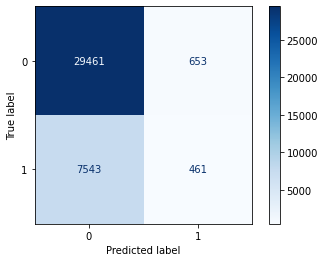

https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-602
Validation
[0 0 0 ... 0 0 0] 

accuracy:  0.7975223514287384
recall:  0.057577565632458236
precision:  0.3867735470941884
f1:  0.10023370553103089
ROC AUC:  0.5176704047913763 

              precision    recall  f1-score   support

           0       0.81      0.98      0.89     13761
           1       0.39      0.06      0.10      3352

    accuracy                           0.80     17113
   macro avg       0.60      0.52      0.49     17113
weighted avg       0.73      0.80      0.73     17113



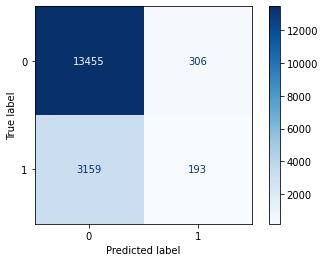

In [ ]:
run_model(clf, train, test, validation, 'XGBClassifier', ['XGBClassifier', 'Raw', 'EDA2'])

In [ ]:
#smotetomek
X = train.loc[:, train.columns != 'No-show']
Y = train["No-show"]

smote_tomek = SMOTETomek(random_state=0)
X_smote, y_smote = smote_tomek.fit_resample(X, Y)

trainSMOTE = pd.DataFrame(data = X_smote, columns = X.columns)
trainSMOTE["No-show"] =  pd.DataFrame(data = y_smote, columns = ["No-show"])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
trainSMOTE

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,7.181698e+14,5.683814e+06,0.000000,1.462953e+09,1.463530e+09,56.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0
1,3.139219e+12,5.711485e+06,1.000000,1.463557e+09,1.464134e+09,52.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,1.000000,0.0,0.0,0.000000,0
2,5.413987e+10,5.599591e+06,1.000000,1.461057e+09,1.462320e+09,54.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0
3,8.996526e+14,5.683539e+06,1.000000,1.462952e+09,1.463530e+09,50.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0
4,8.689745e+13,5.625780e+06,1.000000,1.461742e+09,1.462320e+09,6.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71579,3.916707e+13,5.697827e+06,1.000000,1.463296e+09,1.464775e+09,42.477432,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.093428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0

In [ ]:
#smotetomek
X = test.loc[:, test.columns != 'No-show']
Y = test["No-show"]

smote_tomek = SMOTETomek(random_state=0)
X_smote, y_smote = smote_tomek.fit_resample(X, Y)

testSMOTE = pd.DataFrame(data = X_smote, columns = X.columns)
testSMOTE["No-show"] =  pd.DataFrame(data = y_smote, columns = ["No-show"])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
testSMOTE

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_49,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,9.981638e+12,5.554863e+06,1.000000,1.460020e+09,1.462406e+09,36.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.000000,0
1,3.532219e+13,5.718887e+06,1.000000,1.463653e+09,1.463616e+09,57.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0
2,8.147534e+11,5.719379e+06,0.000000,1.463656e+09,1.464134e+09,49.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,1.000000,0
3,8.147534e+11,5.719401e+06,0.000000,1.463656e+09,1.464134e+09,49.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,0
4,7.667828e+11,5.654881e+06,0.000000,1.462289e+09,1.462752e+09,25.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51035,6.471317e+13,5.467080e+06,0.456074,1.458092e+09,1.462281e+09,48.962606,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-604
Test
[0 0 0 ... 1 1 1] 

accuracy:  0.8792123824451411
recall:  0.7854623824451411
precision:  0.9667229322401736
f1:  0.866717111663604
ROC AUC:  0.8792123824451412 

              precision    recall  f1-score   support

           0       0.82      0.97      0.89     25520
           1       0.97      0.79      0.87     25520

    accuracy                           0.88     51040
   macro avg       0.89      0.88      0.88     51040
weighted avg       0.89      0.88      0.88     51040



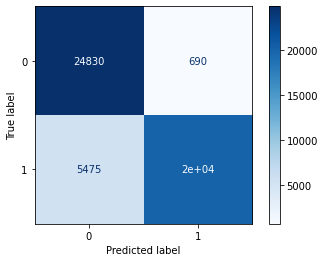

https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-605
Validation
[0 0 0 ... 0 0 0] 

accuracy:  0.7985157482615556
recall:  0.06175417661097852
precision:  0.40588235294117647
f1:  0.10719834282755047
ROC AUC:  0.5198677139867625 

              precision    recall  f1-score   support

           0       0.81      0.98      0.89     13761
           1       0.41      0.06      0.11      3352

    accuracy                           0.80     17113
   macro avg       0.61      0.52      0.50     17113
weighted avg       0.73      0.80      0.73     17113



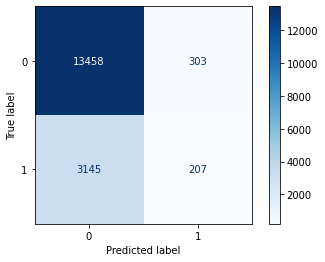

In [ ]:
run_model(clf, trainSMOTE, testSMOTE, validation, 'XGBClassifier', ['XGBClassifier', 'SMOTETomek', 'EDA2'])

In [ ]:
#date
trainSMOTE['ScheduledDay'] =  trainSMOTE['ScheduledDay'].apply(lambda x: datetime.fromtimestamp(x))
trainSMOTE['AppointmentDay'] =  trainSMOTE['AppointmentDay'].apply(lambda x: datetime.fromtimestamp(x))

testSMOTE['ScheduledDay'] =  testSMOTE['ScheduledDay'].apply(lambda x: datetime.fromtimestamp(x))
testSMOTE['AppointmentDay'] =  testSMOTE['AppointmentDay'].apply(lambda x: datetime.fromtimestamp(x))

validation['ScheduledDay'] =  validation['ScheduledDay'].apply(lambda x: datetime.fromtimestamp(x))
validation['AppointmentDay'] =  validation['AppointmentDay'].apply(lambda x: datetime.fromtimestamp(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
trainSMOTE['Waiting_Time_days'] = trainSMOTE['AppointmentDay'] - trainSMOTE['ScheduledDay']
trainSMOTE['Waiting_Time_days'] = trainSMOTE['Waiting_Time_days'].dt.days
trainSMOTE

testSMOTE['Waiting_Time_days'] = testSMOTE['AppointmentDay'] - testSMOTE['ScheduledDay']
testSMOTE['Waiting_Time_days'] = testSMOTE['Waiting_Time_days'].dt.days
testSMOTE

validation['Waiting_Time_days'] = validation['AppointmentDay'] - validation['ScheduledDay']
validation['Waiting_Time_days'] = validation['Waiting_Time_days'].dt.days
validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days
0,29872499824296,5642903,1,2016-04-29 18:38:08,2016-04-29,62,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1
1,558997776694438,5642503,0,2016-04-29 16:08:27,2016-04-29,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
2,4262962299951,5642549,1,2016-04-29 16:19:04,2016-04-29,62,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
3,867951213174,5642828,1,2016-04-29 17:29:31,2016-04-29,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
4,8841186448183,5642494,1,2016-04-29 16:07:23,2016-04-29,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110499,821969177626116,5757697,1,2016-06-01 09:42:56,2016-06-01,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,-1
110500,443438443334614,5787233,1,2016-06-08 09:35:13,2016-06-08,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
110505,56673438855979,5758455,1,2016-06-01 10:45:50,2016-06-01,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
110519,65423877893936,5630447,1,2016-04-27 15:23:14,2016-06-07,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,40


In [ ]:
trainSMOTE[trainSMOTE['Waiting_Time_days'] <-1]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days
15936,2.425226e+13,5.664962e+06,1.0,2016-05-05 13:43:58.000000,2016-05-04,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-2
20833,9.982316e+14,5.686628e+06,1.0,2016-05-11 13:49:20.000000,2016-05-05,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-7
21351,3.787482e+12,5.655637e+06,0.0,2016-05-04 06:50:57.000000,2016-05-03,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-2
45749,9.982316e+14,5.667149e+06,1.0,2016-05-06 17:25:08.685519,2016-05-05,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-2


In [ ]:
trainSMOTE = trainSMOTE[trainSMOTE['Waiting_Time_days'] >=-1]

In [ ]:
trainSMOTE[trainSMOTE['Waiting_Time_days'] <-1]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days


In [ ]:
testSMOTE = testSMOTE[testSMOTE['Waiting_Time_days'] >=-1]

In [ ]:
testSMOTE[testSMOTE['Waiting_Time_days'] <-1]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days


In [ ]:
validation = validation[validation['Waiting_Time_days'] >=-1]

In [ ]:
trainSMOTE

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days
0,7.181698e+14,5.683814e+06,0.000000,2016-05-11 07:54:03.000000,2016-05-18 00:00:00.000000,56.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0,6
1,3.139219e+12,5.711485e+06,1.000000,2016-05-18 07:41:09.000000,2016-05-25 00:00:00.000000,52.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,1.000000,0.0,0.0,0.000000,0,6
2,5.413987e+10,5.599591e+06,1.000000,2016-04-19 09:09:23.000000,2016-05-04 00:00:00.000000,54.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0,14
3,8.996526e+14,5.683539e+06,1.000000,2016-05-11 07:37:14.000000,2016-05-18 00:00:00.000000,50.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0,6
4,8.689745e+13,5.625780e+06,1.000000,2016-04-27 07:34:21.000000,2016-05-04 00:00:00.000000,6.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71579,3.916707e+13,5.697827e+06,1.000000,2016-05-15 07:02:38.272443,2016-06-01 09:52:52.318327,42.477432,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
testSMOTE

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days
0,9.981638e+12,5.554863e+06,1.000000,2016-04-07 09:08:54.000000,2016-05-05 00:00:00.000000,36.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.000000,0,27
1,3.532219e+13,5.718887e+06,1.000000,2016-05-19 10:16:11.000000,2016-05-19 00:00:00.000000,57.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0,-1
2,8.147534e+11,5.719379e+06,0.000000,2016-05-19 11:08:12.000000,2016-05-25 00:00:00.000000,49.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,1.000000,0,5
3,8.147534e+11,5.719401e+06,0.000000,2016-05-19 11:10:47.000000,2016-05-25 00:00:00.000000,49.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,0,5
4,7.667828e+11,5.654881e+06,0.000000,2016-05-03 15:24:48.000000,2016-05-09 00:00:00.000000,25.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51035,6.471317e+13,5.467080e+06,0.456074,2016-03-16 01:39:29.854153,2016-05-03 13:03:15.167723,48.962606,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0

In [ ]:
trainSMOTE['ScheduledWeekday'] = trainSMOTE['ScheduledDay'].dt.dayofweek
trainSMOTE['AppointmentWeekday'] = trainSMOTE['AppointmentDay'].dt.dayofweek

testSMOTE['ScheduledWeekday'] = testSMOTE['ScheduledDay'].dt.dayofweek
testSMOTE['AppointmentWeekday'] = testSMOTE['AppointmentDay'].dt.dayofweek

validation['ScheduledWeekday'] = validation['ScheduledDay'].dt.dayofweek
validation['AppointmentWeekday'] = validation['AppointmentDay'].dt.dayofweek

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
trainSMOTE

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday
0,7.181698e+14,5.683814e+06,0.000000,2016-05-11 07:54:03.000000,2016-05-18 00:00:00.000000,56.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0,6,2,2
1,3.139219e+12,5.711485e+06,1.000000,2016-05-18 07:41:09.000000,2016-05-25 00:00:00.000000,52.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,1.000000,0.0,0.0,0.000000,0,6,2,2
2,5.413987e+10,5.599591e+06,1.000000,2016-04-19 09:09:23.000000,2016-05-04 00:00:00.000000,54.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0,14,1,2
3,8.996526e+14,5.683539e+06,1.000000,2016-05-11 07:37:14.000000,2016-05-18 00:00:00.000000,50.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0,6,2,2
4,8.689745e+13,5.625780e+06,1.000000,2016-04-27 07:34:21.000000,2016-05-04 00:00:00.000000,6.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0,6,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71579,3.916707e+13,5.697827e+06,1.000000,2016-05-15 07:02:38.272443,2016-06-01 09:52:52.318327,42.477432,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.

In [ ]:
testSMOTE

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday
0,9.981638e+12,5.554863e+06,1.000000,2016-04-07 09:08:54.000000,2016-05-05 00:00:00.000000,36.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.000000,0,27,3,3
1,3.532219e+13,5.718887e+06,1.000000,2016-05-19 10:16:11.000000,2016-05-19 00:00:00.000000,57.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0,-1,3,3
2,8.147534e+11,5.719379e+06,0.000000,2016-05-19 11:08:12.000000,2016-05-25 00:00:00.000000,49.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,1.000000,0,5,3,2
3,8.147534e+11,5.719401e+06,0.000000,2016-05-19 11:10:47.000000,2016-05-25 00:00:00.000000,49.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,0,5,3,2
4,7.667828e+11,5.654881e+06,0.000000,2016-05-03 15:24:48.000000,2016-05-09 00:00:00.000000,25.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51035,6.471317e+13,5.467080e+06,0.456074,2016-03-16 01:39:29.854153,2016-05-03 13:03:15.167723,48.962606,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,

In [ ]:
trainSMOTE['ScheduledHour'] = trainSMOTE['ScheduledDay'].dt.hour
testSMOTE['ScheduledHour'] = testSMOTE['ScheduledDay'].dt.hour
validation['ScheduledHour'] = validation['ScheduledDay'].dt.hour

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
trainSMOTE

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour
0,7.181698e+14,5.683814e+06,0.000000,2016-05-11 07:54:03.000000,2016-05-18 00:00:00.000000,56.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0,6,2,2,7
1,3.139219e+12,5.711485e+06,1.000000,2016-05-18 07:41:09.000000,2016-05-25 00:00:00.000000,52.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,1.000000,0.0,0.0,0.000000,0,6,2,2,7
2,5.413987e+10,5.599591e+06,1.000000,2016-04-19 09:09:23.000000,2016-05-04 00:00:00.000000,54.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0,14,1,2,9
3,8.996526e+14,5.683539e+06,1.000000,2016-05-11 07:37:14.000000,2016-05-18 00:00:00.000000,50.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0,6,2,2,7
4,8.689745e+13,5.625780e+06,1.000000,2016-04-27 07:34:21.000000,2016-05-04 00:00:00.000000,6.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0,6,2,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71579,3.916707e+13,5.697827e+06,1.000000,2016-05-15 07:02:38.272443,2016-06-01 09:52:52.318327,42.477432,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000

In [ ]:
testSMOTE

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour
0,9.981638e+12,5.554863e+06,1.000000,2016-04-07 09:08:54.000000,2016-05-05 00:00:00.000000,36.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.000000,0,27,3,3,9
1,3.532219e+13,5.718887e+06,1.000000,2016-05-19 10:16:11.000000,2016-05-19 00:00:00.000000,57.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0,-1,3,3,10
2,8.147534e+11,5.719379e+06,0.000000,2016-05-19 11:08:12.000000,2016-05-25 00:00:00.000000,49.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,1.000000,0,5,3,2,11
3,8.147534e+11,5.719401e+06,0.000000,2016-05-19 11:10:47.000000,2016-05-25 00:00:00.000000,49.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,0,5,3,2,11
4,7.667828e+11,5.654881e+06,0.000000,2016-05-03 15:24:48.000000,2016-05-09 00:00:00.000000,25.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1,5,1,0,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51035,6.471317e+13,5.467080e+06,0.456074,2016-03-16 01:39:29.854153,2016-05-03 13:03:15.167723,48.962606,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
trainSMOTE['ScheduledDay_in_year'] = trainSMOTE['ScheduledDay'].apply(lambda x: x.timetuple().tm_yday)
trainSMOTE['AppointmentDay_in_year'] = trainSMOTE['AppointmentDay'].apply(lambda x: x.timetuple().tm_yday)

testSMOTE['ScheduledDay_in_year'] = testSMOTE['ScheduledDay'].apply(lambda x: x.timetuple().tm_yday)
testSMOTE['AppointmentDay_in_year'] = testSMOTE['AppointmentDay'].apply(lambda x: x.timetuple().tm_yday)

validation['ScheduledDay_in_year'] = validation['ScheduledDay'].apply(lambda x: x.timetuple().tm_yday)
validation['AppointmentDay_in_year'] = validation['AppointmentDay'].apply(lambda x: x.timetuple().tm_yday)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
trainSMOTE

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year
0,7.181698e+14,5.683814e+06,0.000000,2016-05-11 07:54:03.000000,2016-05-18 00:00:00.000000,56.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0,6,2,2,7,132,139
1,3.139219e+12,5.711485e+06,1.000000,2016-05-18 07:41:09.000000,2016-05-25 00:00:00.000000,52.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,1.000000,0.0,0.0,0.000000,0,6,2,2,7,139,146
2,5.413987e+10,5.599591e+06,1.000000,2016-04-19 09:09:23.000000,2016-05-04 00:00:00.000000,54.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0,14,1,2,9,110,125
3,8.996526e+14,5.683539e+06,1.000000,2016-05-11 07:37:14.000000,2016-05-18 00:00:00.000000,50.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0,6,2,2,7,132,139
4,8.689745e+13,5.625780e+06,1.000000,2016-04-27 07:34:21.000000,2016-05-04 00:00:00.000000,6.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0,6,2,2,7,118,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71579,3.916707e+13,5.697827e+06,1.000000,2016-05-15 07:02:38.272443,2016-06-01 09:52:52.318327,42.477432,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0

In [ ]:
testSMOTE

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year
0,9.981638e+12,5.554863e+06,1.000000,2016-04-07 09:08:54.000000,2016-05-05 00:00:00.000000,36.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.000000,0,27,3,3,9,98,126
1,3.532219e+13,5.718887e+06,1.000000,2016-05-19 10:16:11.000000,2016-05-19 00:00:00.000000,57.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0,-1,3,3,10,140,140
2,8.147534e+11,5.719379e+06,0.000000,2016-05-19 11:08:12.000000,2016-05-25 00:00:00.000000,49.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,1.000000,0,5,3,2,11,140,146
3,8.147534e+11,5.719401e+06,0.000000,2016-05-19 11:10:47.000000,2016-05-25 00:00:00.000000,49.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,0,5,3,2,11,140,146
4,7.667828e+11,5.654881e+06,0.000000,2016-05-03 15:24:48.000000,2016-05-09 00:00:00.000000,25.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1,5,1,0,15,124,130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51035,6.471317e+13,5.467080e+06,0.456074,2016-03-16 01:39:29.854153,2016-05-03 13:03:15.167723,48.962606,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,

In [ ]:
trainSMOTE['PatientId'] = trainSMOTE['PatientId'].astype('int')
testSMOTE['PatientId'] = testSMOTE['PatientId'].astype('int')
validation['PatientId'] = validation['PatientId'].astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
trainSMOTE

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year
0,718169788381286,5.683814e+06,0.000000,2016-05-11 07:54:03.000000,2016-05-18 00:00:00.000000,56.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0,6,2,2,7,132,139
1,3139218535988,5.711485e+06,1.000000,2016-05-18 07:41:09.000000,2016-05-25 00:00:00.000000,52.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,1.000000,0.0,0.0,0.000000,0,6,2,2,7,139,146
2,54139872518,5.599591e+06,1.000000,2016-04-19 09:09:23.000000,2016-05-04 00:00:00.000000,54.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0,14,1,2,9,110,125
3,899652635519912,5.683539e+06,1.000000,2016-05-11 07:37:14.000000,2016-05-18 00:00:00.000000,50.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0,6,2,2,7,132,139
4,86897454125357,5.625780e+06,1.000000,2016-04-27 07:34:21.000000,2016-05-04 00:00:00.000000,6.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0,6,2,2,7,118,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71579,39167073873309,5.697827e+06,1.000000,2016-05-15 07:02:38.272443,2016-06-01 09:52:52.318327,42.477432,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0

In [ ]:
trainSMOTE.sample(20)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year
62226,7458784964133,5.686291e+06,1.000000,2016-05-11 16:50:51.867546,2016-05-25 07:41:58.083497,34.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.648464,1,13,2,2,16,132,146
2841,393377412122418,5.680706e+06,1.000000,2016-05-10 12:26:57.000000,2016-05-30 00:00:00.000000,48.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.00000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.00000,1.000000,0,19,1,0,12,131,151
27551,64192437366955,5.594466e+06,1.000000,2016-04-18 10:44:02.000000,2016-05-04 00:00:00.000000,14.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.000000,1,15,0,2,10,109,125
45310,683803297393,5.587977e+06,1.000000,2016-04-16 11:04:26.486796,2016-05-13 01:17:30.359058,69.780996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.380475,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.380475,1.000000,1.0,0.0,1.23905,0.000000,1,26,5,4,11,107,134
33583,88815384699,5.614232e+06,1.000000,2016-04-25 10:14:32.000000,2016-06-07 00:00:00.000000,35.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.00000,1.000000,0,42,0,1,10,116,159
25583,971195619975,5.651635e+06,0.000000,2016-05-03 09:04:10.000000,2016-05-03 00:00:00.000000,69.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0,-1,1,1,9,124,1

In [ ]:
temp = trainSMOTE[trainSMOTE['PatientId']==25435872417332].sort_values('AppointmentDay')
temp.assign(cumsum=temp['No-show'].cumsum())

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_50,Neighbourhood_51,Neighbourhood_52,Neighbourhood_53,Neighbourhood_54,Neighbourhood_55,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,cumsum
28119,25435872417332,5624278,1,1.461685e+09,1.462838e+09,37,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48545,25435872417332,5645786,1,1.462185e+09,1.462838e+09,37,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
83591,25435872417332,5681337,1,1.462889e+09,1.462838e+09,37,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
58820,25435872417332,5622921,1,1.461677e+09,1.464048e+09,37,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2
28076,25435872417332,5681530,1,1.462891e+09,1.464566e+09,37,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2
58641,25435872417332,5681546,1,1.462891e+09,1.464653e+09,37,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3
90748,25435872417332,5756654,1,1.464770e+09,1.464739e+09,37,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
85152,25435872417332,5681564,1,1.462891e+09,1.464912e+09,37,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3
96327,25435872417332,5782554,1,1.465300e+09,1.465258e+09,37,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
96594,25435872417332,5682774,1,1.462906e+09,1.465258e+09,37,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3


In [ ]:
uniquePatientIDTrain = trainSMOTE['PatientId'].unique()
uniquePatientIDTrain

uniquePatientIDTest = testSMOTE['PatientId'].unique()
uniquePatientIDTest

uniquePatientIDValidation = validation['PatientId'].unique()
uniquePatientIDValidation

array([ 29872499824296, 558997776694438,   4262962299951, ...,
        92486975581159,  49292537233329,    164553125429])

In [ ]:
trainSMOTE['cumsum']=0

testSMOTE['cumsum']=0

validation['cumsum']=0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
trainSMOTE

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,cumsum
0,718169788381286,5.683814e+06,0.000000,2016-05-11 07:54:03.000000,2016-05-18 00:00:00.000000,56.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0,6,2,2,7,132,139,0
1,3139218535988,5.711485e+06,1.000000,2016-05-18 07:41:09.000000,2016-05-25 00:00:00.000000,52.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,1.000000,0.0,0.0,0.000000,0,6,2,2,7,139,146,0
2,54139872518,5.599591e+06,1.000000,2016-04-19 09:09:23.000000,2016-05-04 00:00:00.000000,54.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0,14,1,2,9,110,125,0
3,899652635519912,5.683539e+06,1.000000,2016-05-11 07:37:14.000000,2016-05-18 00:00:00.000000,50.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0,6,2,2,7,132,139,0
4,86897454125357,5.625780e+06,1.000000,2016-04-27 07:34:21.000000,2016-05-04 00:00:00.000000,6.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0,6,2,2,7,118,125,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71579,39167073873309,5.697827e+06,1.000000,2016-05-15 07:02:38.272443,2016-06-01 09:52:52.318327,42.477432,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000

In [ ]:
def cumSumFromPatientId(data, patientID):
  temp = data[data['PatientId']==patientID].sort_values('AppointmentDay')
  temp = temp.assign(cumsum=temp['No-show'].cumsum())

  for i in temp.index:
    #print('temp: ',temp.loc[i]['cumsum'])
    data.loc[i, 'cumsum']= temp.loc[i]['cumsum']
    #print(dataset.loc[i])

In [ ]:
for i in uniquePatientIDTrain:
  cumSumFromPatientId(trainSMOTE, i)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
for i in uniquePatientIDTest:
  cumSumFromPatientId(testSMOTE, i)

In [ ]:
for i in uniquePatientIDValidation:
  cumSumFromPatientId(validation, i)

/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [ ]:
testSMOTE[testSMOTE['PatientId']==25435872417332].sort_values('AppointmentDay')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,cumsum
25755,25435872417332,5.681337e+06,1.0,2016-05-10 14:06:51.000000,2016-05-10 00:00:00.000000,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,-1,1,1,14,131,131,0
47107,25435872417332,5.624698e+06,1.0,2016-04-27 00:14:24.656673,2016-05-22 21:53:35.103160,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.922301,1,25,2,6,0,118,143,1
23266,25435872417332,5.622921e+06,1.0,2016-04-26 13:16:31.000000,2016-05-24 00:00:00.000000,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1,27,1,1,13,117,145,2
49755,25435872417332,5.631874e+06,1.0,2016-04-28 16:47:45.233803,2016-05-25 01:39:24.862681,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1,26,3,2,16,119,146,3
44152,25435872417332,5.674766e+06,1.0,2016-05-09 01:25:31.015590,2016-05-27 00:26:46.732726,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.810409,1,17,0,4,1,130,148,4
26392,25435872417332,5.756654e+06,1.0,2016-06-01 08:32:27.000000,2016-06-01 00:00:00.000000,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,-1,2,2,8,153,153,4
25919,25435872417332,5.681564e+06,1.0,2016-05-10 14:39:46.000000,2016-06-03 00:00:00.000000,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0,23,1,4,

In [ ]:
#date
trainSMOTE['ScheduledDay'] = trainSMOTE['ScheduledDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
trainSMOTE['ScheduledDay'] = trainSMOTE['ScheduledDay'].apply(lambda x: datetime.timestamp(x))

testSMOTE['ScheduledDay'] = testSMOTE['ScheduledDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
testSMOTE['ScheduledDay'] = testSMOTE['ScheduledDay'].apply(lambda x: datetime.timestamp(x))

validation['ScheduledDay'] = validation['ScheduledDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
validation['ScheduledDay'] = validation['ScheduledDay'].apply(lambda x: datetime.timestamp(x))

trainSMOTE['AppointmentDay'] = trainSMOTE['AppointmentDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
trainSMOTE['AppointmentDay'] = trainSMOTE['AppointmentDay'].apply(lambda x: datetime.timestamp(x))

testSMOTE['AppointmentDay'] = testSMOTE['AppointmentDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
testSMOTE['AppointmentDay'] = testSMOTE['AppointmentDay'].apply(lambda x: datetime.timestamp(x))

validation['AppointmentDay'] = validation['AppointmentDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
validation['AppointmentDay'] = validation['AppointmentDay'].apply(lambda x: datetime.timestamp(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [ ]:
validation

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_56,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,cumsum
0,29872499824296,5642903,1,1.461955e+09,1.461888e+09,62,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,4,4,18,120,120,0
1,558997776694438,5642503,0,1.461946e+09,1.461888e+09,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,4,4,16,120,120,0
2,4262962299951,5642549,1,1.461947e+09,1.461888e+09,62,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,4,4,16,120,120,0
3,867951213174,5642828,1,1.461951e+09,1.461888e+09,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,4,4,17,120,120,0
4,8841186448183,5642494,1,1.461946e+09,1.461888e+09,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,-1,4,4,16,120,120,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110499,821969177626116,5757697,1,1.464774e+09,1.464739e+09,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,-1,2,2,9,153,153,0
110500,443438443334614,5787233,1,1.465379e+09,1.465344e+09,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,2,2,9,160,160,0
110505,56673438855979,5758455,1,1.464778e+09,1.464739e+09,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,2,2,10,153,153,0
110519,65423877893936,5630447,1,1.461771e+09,1.465258e+09,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,40,2,1,15,118,159,0


https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-608
Test
[0 0 0 ... 1 1 1] 

accuracy:  0.9658307210031348
recall:  0.995141065830721
precision:  0.9400355344980752
f1:  0.9668037155474342
ROC AUC:  0.9658307210031349 

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     25520
           1       0.94      1.00      0.97     25520

    accuracy                           0.97     51040
   macro avg       0.97      0.97      0.97     51040
weighted avg       0.97      0.97      0.97     51040



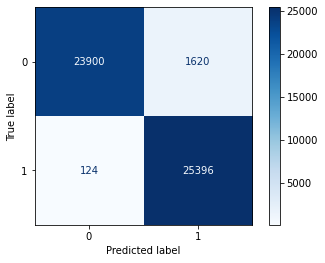

https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-609
Validation
[0 0 0 ... 0 0 0] 

accuracy:  0.8041725105189341
recall:  0.0
precision:  0.0
f1:  0.0
ROC AUC:  0.5 

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     13761
           1       0.00      0.00      0.00      3351

    accuracy                           0.80     17112
   macro avg       0.40      0.50      0.45     17112
weighted avg       0.65      0.80      0.72     17112



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


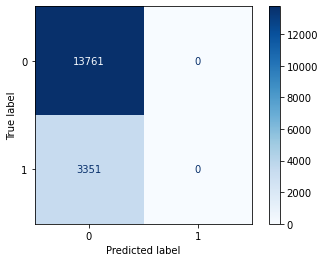

In [ ]:
run_model(clf, trainSMOTE, testSMOTE, validation, 'XGBClassifier', ['XGBClassifier', 'SMOTETomek', 'cumsum','EDA2'])

In [ ]:
def numberOfRecentCancellations(data, patientID):
  temp = data[data['PatientId']==patientID].sort_values('AppointmentDay')
  #print(temp)
  last_index = 0
  for counter, i in enumerate(temp.index):
    #print('temp: ',temp.loc[i]['cumsum'])
    if temp.loc[i, 'No-show'] == 1:
      temp2 = temp.assign(cumsum=temp['No-show'][last_index:].cumsum())
      data.loc[i, 'numberOfRecentCancellations']= temp2.loc[i]['cumsum']-1
    if temp.loc[i, 'No-show'] == 0:  
      last_index = counter

In [ ]:
trainSMOTE['numberOfRecentCancellations']=0

testSMOTE['numberOfRecentCancellations']=0

validation['numberOfRecentCancellations']=0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
for i in uniquePatientIDTrain:
  numberOfRecentCancellations(trainSMOTE, i)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
trainSMOTE

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,cumsum,numberOfRecentCancellations
0,718169788381286,5.683814e+06,0.000000,1.462953e+09,1.463530e+09,56.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0,6,2,2,7,132,139,0,0.0
1,3139218535988,5.711485e+06,1.000000,1.463557e+09,1.464134e+09,52.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,1.000000,0.0,0.0,0.000000,0,6,2,2,7,139,146,0,0.0
2,54139872518,5.599591e+06,1.000000,1.461057e+09,1.462320e+09,54.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0,14,1,2,9,110,125,0,0.0
3,899652635519912,5.683539e+06,1.000000,1.462952e+09,1.463530e+09,50.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0,6,2,2,7,132,139,0,0.0
4,86897454125357,5.625780e+06,1.000000,1.461742e+09,1.462320e+09,6.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0,6,2,2,7,118,125,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71579,39167073873309,5.697827e+06,1.000000,1.463296e+09,1.464775e+09,42.477432,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.093428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
for i in uniquePatientIDTest:
  numberOfRecentCancellations(testSMOTE, i)

In [ ]:
testSMOTE

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,cumsum,numberOfRecentCancellations
0,9981638424867,5.554863e+06,1.000000,1.460020e+09,1.462406e+09,36.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.000000,0,27,3,3,9,98,126,0,0.0
1,35322194632753,5.718887e+06,1.000000,1.463653e+09,1.463616e+09,57.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0,-1,3,3,10,140,140,0,0.0
2,814753424819,5.719379e+06,0.000000,1.463656e+09,1.464134e+09,49.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,1.000000,0,5,3,2,11,140,146,0,0.0
3,814753424819,5.719401e+06,0.000000,1.463656e+09,1.464134e+09,49.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,0,5,3,2,11,140,146,0,0.0
4,766782756178,5.654881e+06,0.000000,1.462289e+09,1.462752e+09,25.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1,5,1,0,15,124,130,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51035,64713169090709,5.467080e+06,0.456074,1.458092e+09,1.462281e+09,48.962606,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.456074,0.000000,0.543926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
for i in uniquePatientIDValidation:
  numberOfRecentCancellations(validation, i)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
validation

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,cumsum,numberOfRecentCancellations
0,29872499824296,5642903,1,1.461955e+09,1.461888e+09,62,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,4,4,18,120,120,0,0.0
1,558997776694438,5642503,0,1.461946e+09,1.461888e+09,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,4,4,16,120,120,0,0.0
2,4262962299951,5642549,1,1.461947e+09,1.461888e+09,62,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,4,4,16,120,120,0,0.0
3,867951213174,5642828,1,1.461951e+09,1.461888e+09,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,4,4,17,120,120,0,0.0
4,8841186448183,5642494,1,1.461946e+09,1.461888e+09,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,-1,4,4,16,120,120,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110499,821969177626116,5757697,1,1.464774e+09,1.464739e+09,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,-1,2,2,9,153,153,0,0.0
110500,443438443334614,5787233,1,1.465379e+09,1.465344e+09,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,2,2,9,160,160,0,0.0
110505,56673438855979,5758455,1,1.464778e+09,1.464739e+09,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,2,2,10,153,153,0,0.0
110519,65423877893936,5630447,1,1.461771e+09,1.465258e+09,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,40,2,1,15,118,159,0,0.0


In [ ]:
testSMOTE[testSMOTE['PatientId']==46784193141591].sort_values('AppointmentDay')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,...,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,cumsum,numberOfRecentCancellations
39267,46784193141591,5.681133e+06,0.0,1.462781e+09,1.462739e+09,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,-1,0,6,8,130,129,1,0.0
43103,46784193141591,5.689801e+06,0.0,1.463013e+09,1.462979e+09,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,-1,3,2,0,133,132,2,1.0
22520,46784193141591,5.691871e+06,0.0,1.463061e+09,1.463011e+09,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,-1,3,3,13,133,133,2,0.0
22528,46784193141591,5.692074e+06,0.0,1.463063e+09,1.463011e+09,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,-1,3,3,14,133,133,2,0.0
42865,46784193141591,5.693280e+06,0.0,1.463098e+09,1.463066e+09,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,-1,4,3,0,134,133,3,0.0
47650,46784193141591,5.694648e+06,0.0,1.463129e+09,1.463098e+09,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,-1,4,4,8,134,134,4,1.0
22655,46784193141591,5.694710e+06,0.0,1.463130e+09,1.463098e+09,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,-1,4,4,8,134,134,5,2.0
22523,46784193141591,5.694442e+06,0.0,1.463129e+09,1.463098e+09,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
#date
trainSMOTE['ScheduledDay'] = trainSMOTE['ScheduledDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
trainSMOTE['ScheduledDay'] = trainSMOTE['ScheduledDay'].apply(lambda x: datetime.timestamp(x))

testSMOTE['ScheduledDay'] = testSMOTE['ScheduledDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
testSMOTE['ScheduledDay'] = testSMOTE['ScheduledDay'].apply(lambda x: datetime.timestamp(x))

validation['ScheduledDay'] = validation['ScheduledDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
validation['ScheduledDay'] = validation['ScheduledDay'].apply(lambda x: datetime.timestamp(x))

trainSMOTE['AppointmentDay'] = trainSMOTE['AppointmentDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
trainSMOTE['AppointmentDay'] = trainSMOTE['AppointmentDay'].apply(lambda x: datetime.timestamp(x))

testSMOTE['AppointmentDay'] = testSMOTE['AppointmentDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
testSMOTE['AppointmentDay'] = testSMOTE['AppointmentDay'].apply(lambda x: datetime.timestamp(x))

validation['AppointmentDay'] = validation['AppointmentDay'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%dT%H:%M:%SZ'))
validation['AppointmentDay'] = validation['AppointmentDay'].apply(lambda x: datetime.timestamp(x))

https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-610
Test
[0 0 0 ... 1 1 1] 

accuracy:  0.9771551724137931
recall:  0.9936912225705329
precision:  0.9618798361401911
f1:  0.9775267905327268
ROC AUC:  0.9771551724137929 

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     25520
           1       0.96      0.99      0.98     25520

    accuracy                           0.98     51040
   macro avg       0.98      0.98      0.98     51040
weighted avg       0.98      0.98      0.98     51040



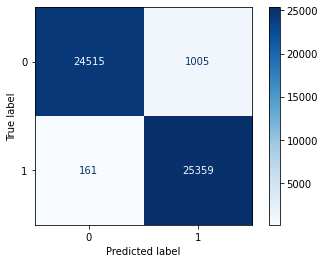

https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-611
Validation
[0 0 0 ... 0 0 0] 

accuracy:  0.8041725105189341
recall:  0.0
precision:  0.0
f1:  0.0
ROC AUC:  0.5 

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     13761
           1       0.00      0.00      0.00      3351

    accuracy                           0.80     17112
   macro avg       0.40      0.50      0.45     17112
weighted avg       0.65      0.80      0.72     17112



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


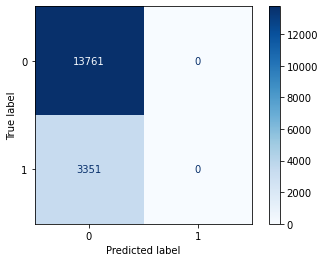

In [ ]:
run_model(clf, trainSMOTE, testSMOTE, validation, 'XGBClassifier', ['XGBClassifier', 'SMOTETomek', 'cumsum','numberOfRecentCancellations','EDA2'])

In [ ]:
trainSMOTE['numberOfRecentCancellations']=0

testSMOTE['numberOfRecentCancellations']=0

validation['numberOfRecentCancellations']=0

In [ ]:
trainSMOTE.drop("ScheduledDay", inplace = True, axis=1)
testSMOTE.drop("ScheduledDay", inplace = True, axis=1)
validation.drop("ScheduledDay", inplace = True, axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
trainSMOTE.drop("AppointmentDay", inplace = True, axis=1)
testSMOTE.drop("AppointmentDay", inplace = True, axis=1)
validation.drop("AppointmentDay", inplace = True, axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
trainSMOTE.drop("AppointmentID", inplace = True, axis=1)
testSMOTE.drop("AppointmentID", inplace = True, axis=1)
validation.drop("AppointmentID", inplace = True, axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
trainSMOTE.drop("PatientId", inplace = True, axis=1)
testSMOTE.drop("PatientId", inplace = True, axis=1)
validation.drop("PatientId", inplace = True, axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
trainSMOTE

,Gender,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,Neighbourhood_35,Neighbourhood_36,Neighbourhood_37,Neighbourhood_38,...,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,cumsum,numberOfRecentCancellations
0,0.000000,56.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0,6,2,2,7,132,139,0,0.0
1,1.000000,52.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,1.000000,0.0,0.0,0.000000,0,6,2,2,7,139,146,0,0.0
2,1.000000,54.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0,14,1,2,9,110,125,0,0.0
3,1.000000,50.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0,6,2,2,7,132,139,0,0.0
4,1.000000,6.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.000000,0,6,2,2,7,118,125,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71579,1.000000,42.477432,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.093428,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.906572,1,17,6,2,7,136,153,1,0.0
71580,0.275005,8.275005,0.724995,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
testSMOTE

,Gender,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,Neighbourhood_35,Neighbourhood_36,Neighbourhood_37,Neighbourhood_38,...,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,cumsum,numberOfRecentCancellations
0,1.000000,36.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.000000,0,27,3,3,9,98,126,0,0.0
1,1.000000,57.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0,-1,3,3,10,140,140,0,0.0
2,0.000000,49.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,1.000000,0,5,3,2,11,140,146,0,0.0
3,0.000000,49.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,0,5,3,2,11,140,146,0,0.0
4,0.000000,25.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1,5,1,0,15,124,130,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51035,0.456074,48.962606,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.456074,0.000000,0.543926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.456074,0.000000,0.0,0.0,1.000000,1,48,2,1,1,76,124,1,0.0
51036,1.000000,55.638691,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
validation

,Gender,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,Neighbourhood_35,Neighbourhood_36,Neighbourhood_37,Neighbourhood_38,...,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,cumsum,numberOfRecentCancellations
0,1,62,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,4,4,18,120,120,0,0.0
1,0,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,4,4,16,120,120,0,0.0
2,1,62,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,4,4,16,120,120,0,0.0
3,1,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,4,4,17,120,120,0,0.0
4,1,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,-1,4,4,16,120,120,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110499,1,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,-1,2,2,9,153,153,0,0.0
110500,1,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,2,2,9,160,160,0,0.0
110505,1,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,2,2,10,153,153,0,0.0
110519,1,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,40,2,1,15,118,159,0,0.0


In [ ]:
run_model(clf, trainSMOTE, testSMOTE, validation, 'XGBClassifier', ['XGBClassifier', 'SMOTETomek', 'drop','EDA2'])

https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-616


AttributeError: ignored

In [ ]:
validation

,Gender,Age,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Neighbourhood_8,Neighbourhood_9,Neighbourhood_10,Neighbourhood_11,Neighbourhood_12,Neighbourhood_13,Neighbourhood_14,Neighbourhood_15,Neighbourhood_16,Neighbourhood_17,Neighbourhood_18,Neighbourhood_19,Neighbourhood_20,Neighbourhood_21,Neighbourhood_22,Neighbourhood_23,Neighbourhood_24,Neighbourhood_25,Neighbourhood_26,Neighbourhood_27,Neighbourhood_28,Neighbourhood_29,Neighbourhood_30,Neighbourhood_31,Neighbourhood_32,Neighbourhood_33,Neighbourhood_34,Neighbourhood_35,Neighbourhood_36,Neighbourhood_37,Neighbourhood_38,...,Neighbourhood_57,Neighbourhood_58,Neighbourhood_59,Neighbourhood_60,Neighbourhood_61,Neighbourhood_62,Neighbourhood_63,Neighbourhood_64,Neighbourhood_65,Neighbourhood_66,Neighbourhood_67,Neighbourhood_68,Neighbourhood_69,Neighbourhood_70,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80,Neighbourhood_81,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,ScheduledHour,ScheduledDay_in_year,AppointmentDay_in_year,cumsum,numberOfRecentCancellations
0,1,62,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,4,4,18,120,120,0,0.0
1,0,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,4,4,16,120,120,0,0.0
2,1,62,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,4,4,16,120,120,0,0.0
3,1,8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,4,4,17,120,120,0,0.0
4,1,56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,-1,4,4,16,120,120,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110499,1,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,-1,2,2,9,153,153,0,0.0
110500,1,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,2,2,9,160,160,0,0.0
110505,1,55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,2,2,10,153,153,0,0.0
110519,1,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,40,2,1,15,118,159,0,0.0


In [ ]:
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1, importance_type='gain', interaction_constraints='', learning_rate=0.300000012, max_delta_step=0, max_depth=6, min_child_weight=1, missing=None, monotone_constraints='()', n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact', validate_parameters=1, verbosity=None)


In [ ]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-617
Test
[0 0 0 ... 1 1 1] 

accuracy:  0.9769592476489029
recall:  0.993103448275862
precision:  0.962040692377771
f1:  0.9773253123553911
ROC AUC:  0.9769592476489027 

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     25520
           1       0.96      0.99      0.98     25520

    accuracy                           0.98     51040
   macro avg       0.98      0.98      0.98     51040
weighted avg       0.98      0.98      0.98     51040



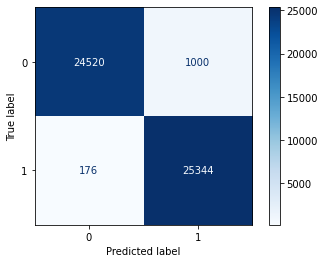

https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-618
Validation
[0 0 0 ... 0 0 0] 

accuracy:  0.8041725105189341
recall:  0.0
precision:  0.0
f1:  0.0
ROC AUC:  0.5 

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     13761
           1       0.00      0.00      0.00      3351

    accuracy                           0.80     17112
   macro avg       0.40      0.50      0.45     17112
weighted avg       0.65      0.80      0.72     17112



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


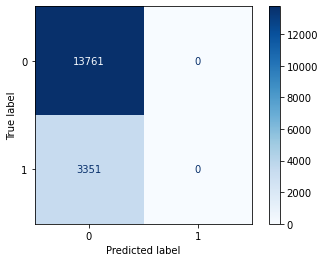

In [ ]:
run_model(clf, trainSMOTE, testSMOTE, validation, 'XGBClassifier', ['XGBClassifier', 'SMOTETomek', 'hyperparametr','EDA2'])